In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mushroom-classification/mushrooms.csv


**I will use the data to try to find the best model to predict whether or not a mushroom is poisonous or edible.**

In [2]:
shrooms = pd.read_csv('../input/mushroom-classification/mushrooms.csv')
shrooms.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


****Look into the data

In [3]:
shrooms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

1. All data types are object, no integers
* The target in this data is 'class', which has two values, 'e' for edible or 'p' for posionous

We can observe the class columns with frequency value and bar charts

------class------


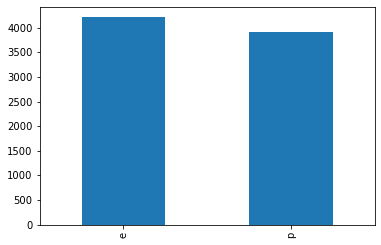

------cap-shape------


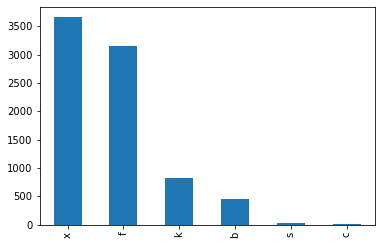

------cap-surface------


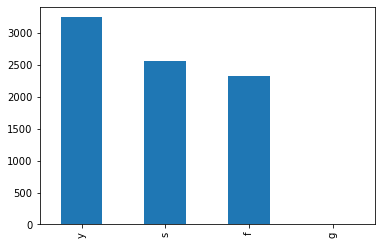

------cap-color------


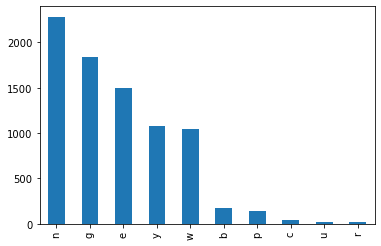

------bruises------


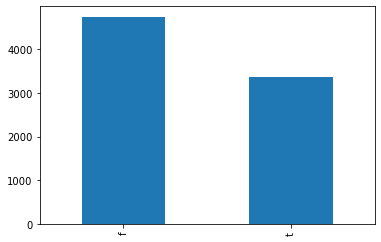

------odor------


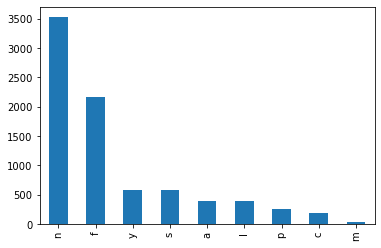

------gill-attachment------


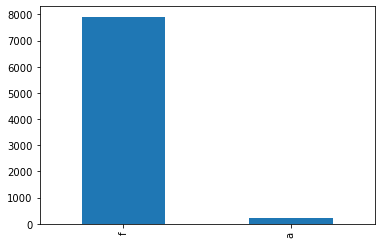

------gill-spacing------


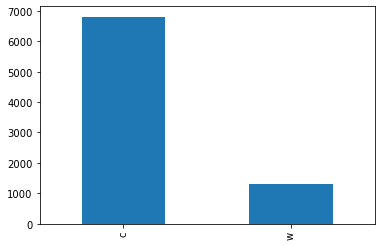

------gill-size------


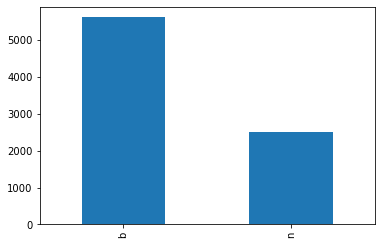

------gill-color------


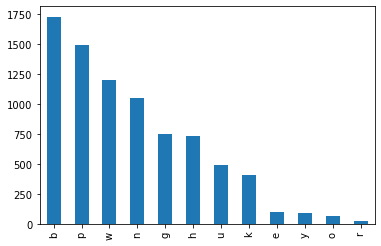

------stalk-shape------


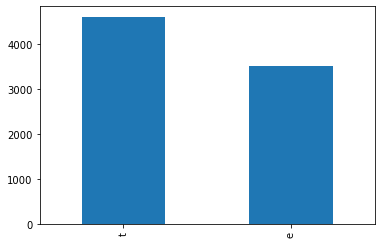

------stalk-root------


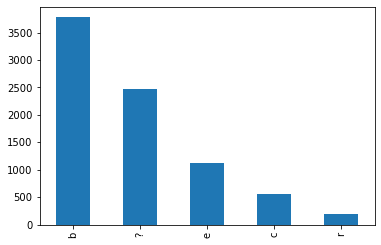

------stalk-surface-above-ring------


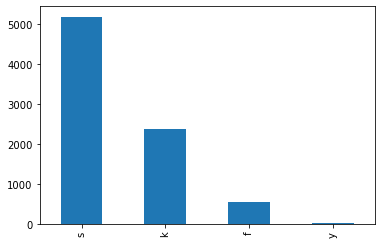

------stalk-surface-below-ring------


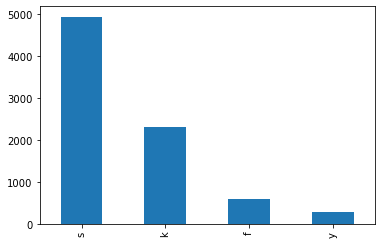

------stalk-color-above-ring------


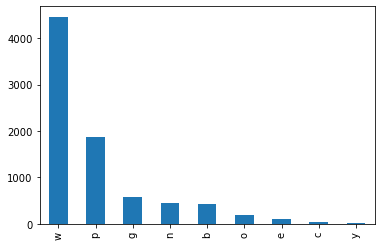

------stalk-color-below-ring------


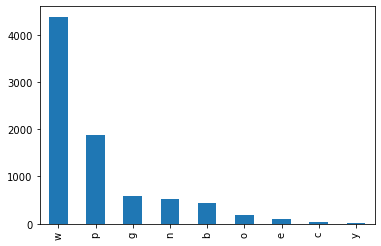

------veil-type------


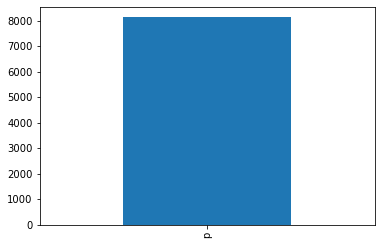

------veil-color------


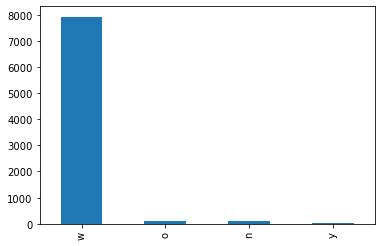

------ring-number------


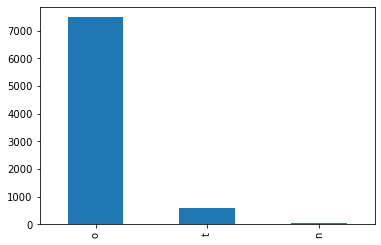

------ring-type------


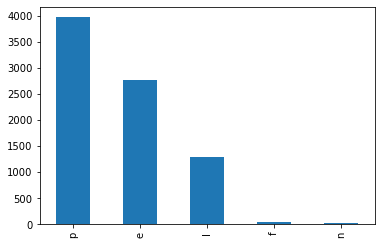

------spore-print-color------


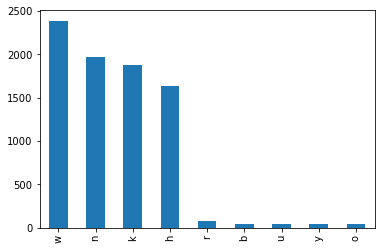

------population------


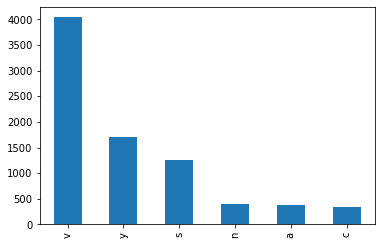

------habitat------


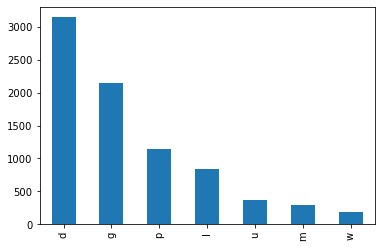

In [4]:
from matplotlib import pyplot as plt  #import matplotlib.pyplot and alias it as plt

for column in shrooms.select_dtypes(object).columns: 
    print('------' + str(column) + '------')
    shrooms[column].value_counts().plot.bar()
    plt.show()

We will convert 'e' and 'p' to 1 and 0 for better uses with sklearn

In [5]:
Y = np.zeros(shrooms.shape[0])           #create a vector of zeros with size = the data
Y[shrooms['class']=='e'] = 1                  #when the actual target is 'e', Y is assigned 1
shrooms['class'] = Y                          #assign the new labels back to the data 

In [6]:
shrooms.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,0.0,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,1.0,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,1.0,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,0.0,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,1.0,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


<h3> Train/Test Splitting </h3>
* Use stratified split to preserve the distribution of the target

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit
#set the parameters
split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

#now we need to provide a stratified column, the target is column 'class', so let's use that
for train_index, test_index in split.split(shrooms, shrooms['class']):
    strat_train_set = shrooms.loc[train_index]
    strat_test_set = shrooms.loc[test_index]
    
#split the target from the set
trainX = strat_train_set.iloc[:,1:]
trainY = strat_train_set.iloc[:,0]
trainX.shape, trainY.shape

((6093, 22), (6093,))

Check the distributions

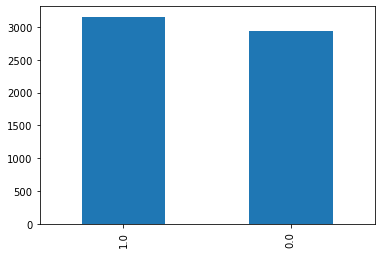

In [8]:
ax1 = strat_train_set['class'].value_counts().plot.bar()

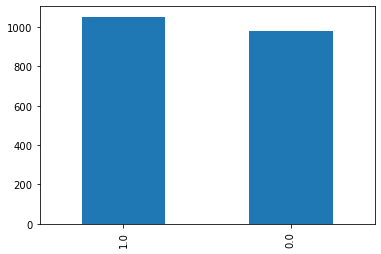

In [9]:
ax1 = strat_test_set['class'].value_counts().plot.bar()

One Hot Encoder on the class columns

In [10]:
from sklearn.preprocessing import OneHotEncoder


onehot = OneHotEncoder(sparse=False)
trainX_Encoded = onehot.fit_transform(trainX.select_dtypes(object))

print(trainX_Encoded)

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


<h3>Modeling</h3>

<h4>Logistic Regression</h4>

Accuracy:

In [11]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression()

from sklearn.model_selection import cross_val_score

accuracy_3cv = cross_val_score(logistic, trainX_Encoded, trainY, cv=3, scoring="accuracy")
print(accuracy_3cv)
print(accuracy_3cv.mean())

[0.9985229 1.        1.       ]
0.999507631708518


Confusion Matrix:

In [12]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(logistic, trainX_Encoded, trainY, cv=3)

from sklearn.metrics import confusion_matrix

conf_matrx = confusion_matrix(trainY, y_train_pred)

print(conf_matrx)

[[2934    3]
 [   0 3156]]


F1-Score:

In [13]:
from sklearn.metrics import f1_score
f1_score(trainY, y_train_pred)

0.9995249406175772

Let also try <b>Random Forest</b>

In [14]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

accuracy_3cv = cross_val_score(rf, trainX_Encoded, trainY, cv=3, scoring="accuracy")
print(accuracy_3cv)
print(accuracy_3cv.mean())

[1. 1. 1.]
1.0


Confusion Matrix:

In [15]:
y_train_pred_rf = cross_val_predict(rf, trainX_Encoded, trainY, cv=3)

conf_matrx = confusion_matrix(trainY, y_train_pred_rf)

print(conf_matrx)

[[2937    0]
 [   0 3156]]


F1-Score:

In [16]:
f1_score(trainY, y_train_pred_rf)

1.0

Random Forest predicts the target with 100% accuracy. Problem is solved no further testing is needed. 

Test the Random Forest model on the test set

In [18]:
#split the target from the set
testX = strat_test_set.iloc[:,1:]
testY = strat_test_set.iloc[:,0]
testX.shape, testY.shape

((2031, 22), (2031,))

In [19]:
accuracy_3cv = cross_val_score(rf, trainX_Encoded, trainY, cv=3, scoring="accuracy")
print(accuracy_3cv)
print(accuracy_3cv.mean())

[1. 1. 1.]
1.0


In [20]:
f1_score(trainY, y_train_pred_rf)

1.0

In [ ]:
The Random Forest model is validated on the test set.

The Random Forest model is validated on the test set.